In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import xarray as xr
import pandas as pd
import os, sys
from scipy import interpolate
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
import pickle, warnings
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
from scipy.interpolate import interp1d

In [2]:
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/traj/"))
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/utilities/"))
#from traj_psd_obs import traj_psd
from plotting_utilities import *
#from densityPlot import *
from flighttrack import *
#from thermodynamic_functions import *

farbe = sim_colors()

In [3]:
# Constants needed for mixing ratio conversion
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap

# Figure 1: Small subdomain and measurements over domain + synthetic flight track idea

In [9]:
# Flight 7 track
basedir = '/groups/sylvia/UTLS-profiles/'
scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
sc_data = xr.open_dataset(scfi)
lat_sc = sc_data['BEST:LAT'].values
lon_sc = sc_data['BEST:LON'].values
t_sc = sc_data['time'].values
i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

# External parameter file with topography
dset = xr.open_dataset( '/xdisk/sylvia/extpar_icon-grid_tropic_55e115e5s40n_R2500m_bitmap.nc' )

In [10]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

In [11]:
# MLS data
bd = '/groups/sylvia/UTLS-profiles/obs/'
filename = 'MLS-Aura_L2GP-Temperature_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_temperature = f['HDFEOS/SWATHS/Temperature/Data Fields/Temperature'][:]  # (3495, 55)
    mls_lat = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Latitude'][:] # (3495, )
    mls_lon = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure1 = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (mls_lon >= 80) & (mls_lon <= 90) & (mls_lat >= 19) & (mls_lat <=30) )
mls_lon_filtered = mls_lon[mask]
mls_lat_filtered = mls_lat[mask]

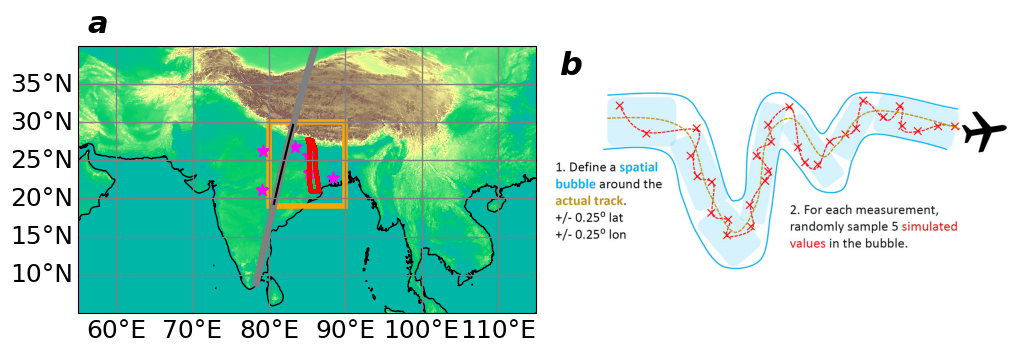

In [20]:
fs = 18
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(1,2,width_ratios=[3,3])

# Set up grid in panel a
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':fs}
gl.ylabel_style = {'size':fs}
ax0.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
ax0.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)
ax0.set_extent([55, 115, 5, 40],crs=ccrs.PlateCarree())

# Add the time-consuming topography under the map
cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
x, y = dset['lon'].values, dset['lat'].values
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
ax0.coastlines()

# Create and add a rectangle for the small subdomain
lon_min, lon_max = 80, 90
lat_min, lat_max = 19, 30
box = mpatches.Rectangle( (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=4,
    edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree() )
ax0.add_patch(box)

# Plot the sonde locations
sz = 80
ax0.scatter( 83.360, 26.750, marker='*', color='magenta', s=sz ) # Station 42379 
ax0.scatter( 85.1, 25.600, marker='*', color='magenta', s=sz ) # Station 42492
ax0.scatter( 85.310, 23.310, marker='*', color='magenta', s=sz ) # Station 42701 
ax0.scatter( 79.050, 21.100, marker='*', color='magenta', s=sz ) # Station 42867
ax0.scatter( 88.45079, 22.650, marker='*', color='magenta', s=sz ) # Station 42809
ax0.scatter( 79.250, 26.230, marker='*', color='magenta', s=sz ) # Station 42361

# Plot the MLS track
ax0.plot( mls_lon[2800:3000], mls_lat[2800:3000], color='gray', lw=5, transform=ccrs.PlateCarree() )
ax0.plot( mls_lon_filtered, mls_lat_filtered, color='black', linestyle='-', transform=ccrs.PlateCarree() )

# Plot the Flight 7 Track
ax0.scatter( lon_sc[i_sc[:,0]], lat_sc[i_sc[:,0]], c='red', s=2, transform=ccrs.PlateCarree() ) 
ax0.text(0.02 ,1.05, 'a', weight='bold', fontstyle='italic', fontsize=fs+4, transform=ax0.transAxes)

# Add the synthetic flight track schematic to panel b
ax1 = fig.add_subplot(gs[0,1])
img = plt.imread( '/groups/sylvia/UTLS-profiles/output/syn-flight-track-schematic.jpg' )
plt.imshow( img )
plt.axis('off')
ax1.text(0.02 ,1.05, 'b', weight='bold', fontstyle='italic', fontsize=fs+5, transform=ax1.transAxes)

fig.subplots_adjust(wspace=0.03)
#fig.savefig('/groups/sylvia/UTLS-profiles/output/domain-obs-syntrajs.png', bbox_inches='tight')
plt.show()

# Figure 2: trajectories over domain

In [3]:
# Read in a sample 51-hour long trajectory file. Initialize empty arrays for altitude, latitude, longitude.
fi_name = '/groups/sylvia/UTLS-profiles/output/traj_tst00000450_p011.nc'
timesteps = 7651
numtraj = xr.open_dataset(fi_name).dims['id']

traj_alt = np.zeros((timesteps,numtraj))
traj_lat = np.zeros((timesteps,numtraj))
traj_lon = np.zeros((timesteps,numtraj))

In [4]:
# Read in the altitude, longitude, latitude values
fi = xr.open_dataset(fi_name)
alt = fi.alt.values
lon = fi.lon.values
lat = fi.lat.values
t = fi.t.values
rtime = fi.rtime.values

# Find indices where the matrix != 0.
xs, ys = np.where(alt != 0)
# Extract the square with extreme limits.
# In limited testing, this seems always to generate [=] (88,5308)
alt = alt[:max(xs)+1,:max(ys)+1]
lon = lon[:max(xs)+1,:max(ys)+1]
lat = lat[:max(xs)+1,:max(ys)+1]
rtime = rtime[:max(xs)+1]

In [1]:
# Store the trimmed matrices.
temp1 = alt/1000.
temp2 = rad2deg(lat)
temp3 = rad2deg(lon)

# Mask the negative altitudes and fill values (-999.) for latitudes and longitudes.
traj_alt = np.where((temp1 > 0), temp1, np.nan)
traj_lat = np.where((temp2 >= -90.), temp2, np.nan)
traj_lon = np.where((temp3 >= -180.), temp3, np.nan)

NameError: name 'alt' is not defined

In [ ]:
# How many trajectories to plot? Overlay on topography in purple.
norm = plt.Normalize(5,22)
n = 100
for i in np.arange(n):
    # Create a set of line segments to color individually. Points in N x 1 x 2 array.
    points = np.array([traj_lon[:,i],traj_lat[:,i]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments,cmap='Purples',norm=norm)
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(0.5)
    line = ax0.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap='Purples',norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

def resize_colorbar(event):
    plt.draw()
    posn = ax0.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0, 0.03, posn.height])
    
fig.canvas.mpl_connect('resize_event', resize_colorbar)
c = plt.colorbar(sm, cax=cbar_ax)
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
resize_colorbar(None)

# Figure 3: Temperature and pressure along the flight tracks

In [7]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
T = syn_traj.temp.values
P = syn_traj.pressure.values/100
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
T_Stratoclim = daten['BEST:TEMP']
P_Stratoclim = daten['BEST:PRESS']
t_Stratoclim = daten['time']

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


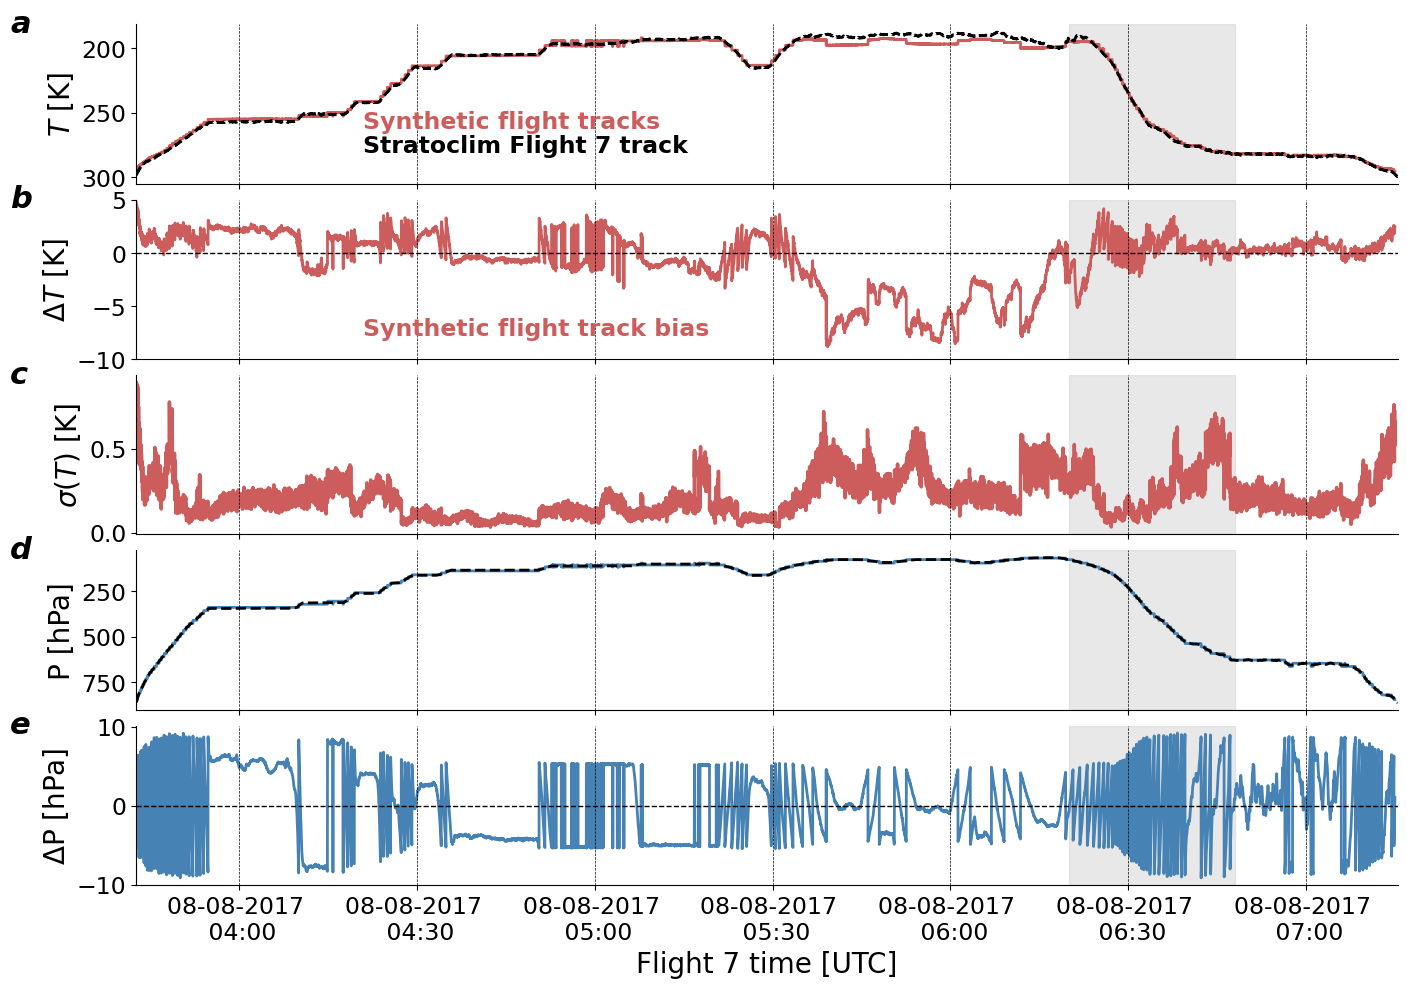

In [8]:
fs = 17
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14,10))
let = ['a', 'b', 'c', 'd', 'e']
for a, l, i in zip(ax, let, np.arange(5)):
    a.set_xlim( [t.min(), t.max()] )
    a.axvspan( np.datetime64('2017-08-08T06:20'), np.datetime64('2017-08-08T06:48'), color='lightgray', alpha=0.5 )
    sexy_axes(a, fs=fs, r=False)
    a.text(-0.1, 0.95, l, weight='bold', style='italic', fontsize=fs+5, transform=a.transAxes)
    if i < 4:
        a.set_xticklabels([])
        
Tm = np.nanmean( T, axis=1 )
Tstd = np.nanstd( T, axis=1 )
Pm = np.nanmean( P, axis=1 )

ax[0].plot(t, Tm, color='indianred', lw=2)
ax[0].plot(t_Stratoclim, T_Stratoclim, color='k', lw=2, ls='--')
ax[0].set_ylabel(r'$T$ [K]', fontsize=fs+3)
ax[0].invert_yaxis()
ax[0].text(0.18, 0.2, 'Stratoclim Flight 7 track', weight='bold', fontsize=fs, transform=ax[0].transAxes)
ax[0].text(0.18, 0.35, 'Synthetic flight tracks',  weight='bold', fontsize=fs, color='indianred', transform=ax[0].transAxes)

ax[1].plot(t, T_Stratoclim - Tm, color='indianred', linewidth=2)
ax[1].axhline( y=0, color='k', ls='--', lw=1 )
ax[1].set_ylabel(r'$\Delta T$ [K]', fontsize=fs+3)
ax[1].text(0.18, 0.15, 'Synthetic flight track bias',  weight='bold', fontsize=fs, color='indianred', transform=ax[1].transAxes)
ax[1].set_ylim([-10, 5])

ax[2].plot(t, Tstd, color='indianred', linewidth=2.5)
ax[2].set_ylabel(r'$\sigma(T)$ [K]', fontsize=fs+3)

ax[3].plot(t, Pm, color='steelblue', lw=2)
ax[3].plot(t, P_Stratoclim, color='k', ls='--', lw=2)
ax[3].invert_yaxis()
ax[3].set_ylabel( 'P [hPa]', fontsize=fs+3 )

ax[4].plot(t, P_Stratoclim - Pm, color='steelblue', lw=2)
ax[4].axhline( y=0, color='k', ls='--', lw=1 )
ax[4].spines['top'].set_color('none')
ax[4].tick_params('both',labelsize=fs)
ax[4].set_ylabel( r'$\Delta$P [hPa]', fontsize=fs+3 )
ax[4].set_xticklabels(['08-08-2017 \n 04:00', '08-08-2017 \n 04:30','08-08-2017 \n 05:00','08-08-2017 \n 05:30',
    '08-08-2017 \n 06:00','08-08-2017 \n 06:30','08-08-2017 \n 07:00'])
ax[4].set_xlabel('Flight 7 time [UTC]', fontsize=fs+3)

for xtick in ax[4].get_xticks():
    for a in ax:
        a.axvline(x=xtick, color='k', ls='--', lw=0.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
#fig.savefig('output/syn-flight-track-TPcheck.pdf',bbox_inches='tight')
plt.show()

# Figure 4: Cloud and moisture along the flight tracks

In [38]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
qv_sim = syn_traj.qv.values * conv * 10**6
qi_sim = syn_traj.qi.values * conv * 10**6
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
qv_Stratoclim1 = daten['BEST:H2O_enh']
qv_Stratoclim2 = daten['BEST:H2O_gas']
qi_Stratoclim = daten['BEST:IWC']
t_Stratoclim = daten['time']

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


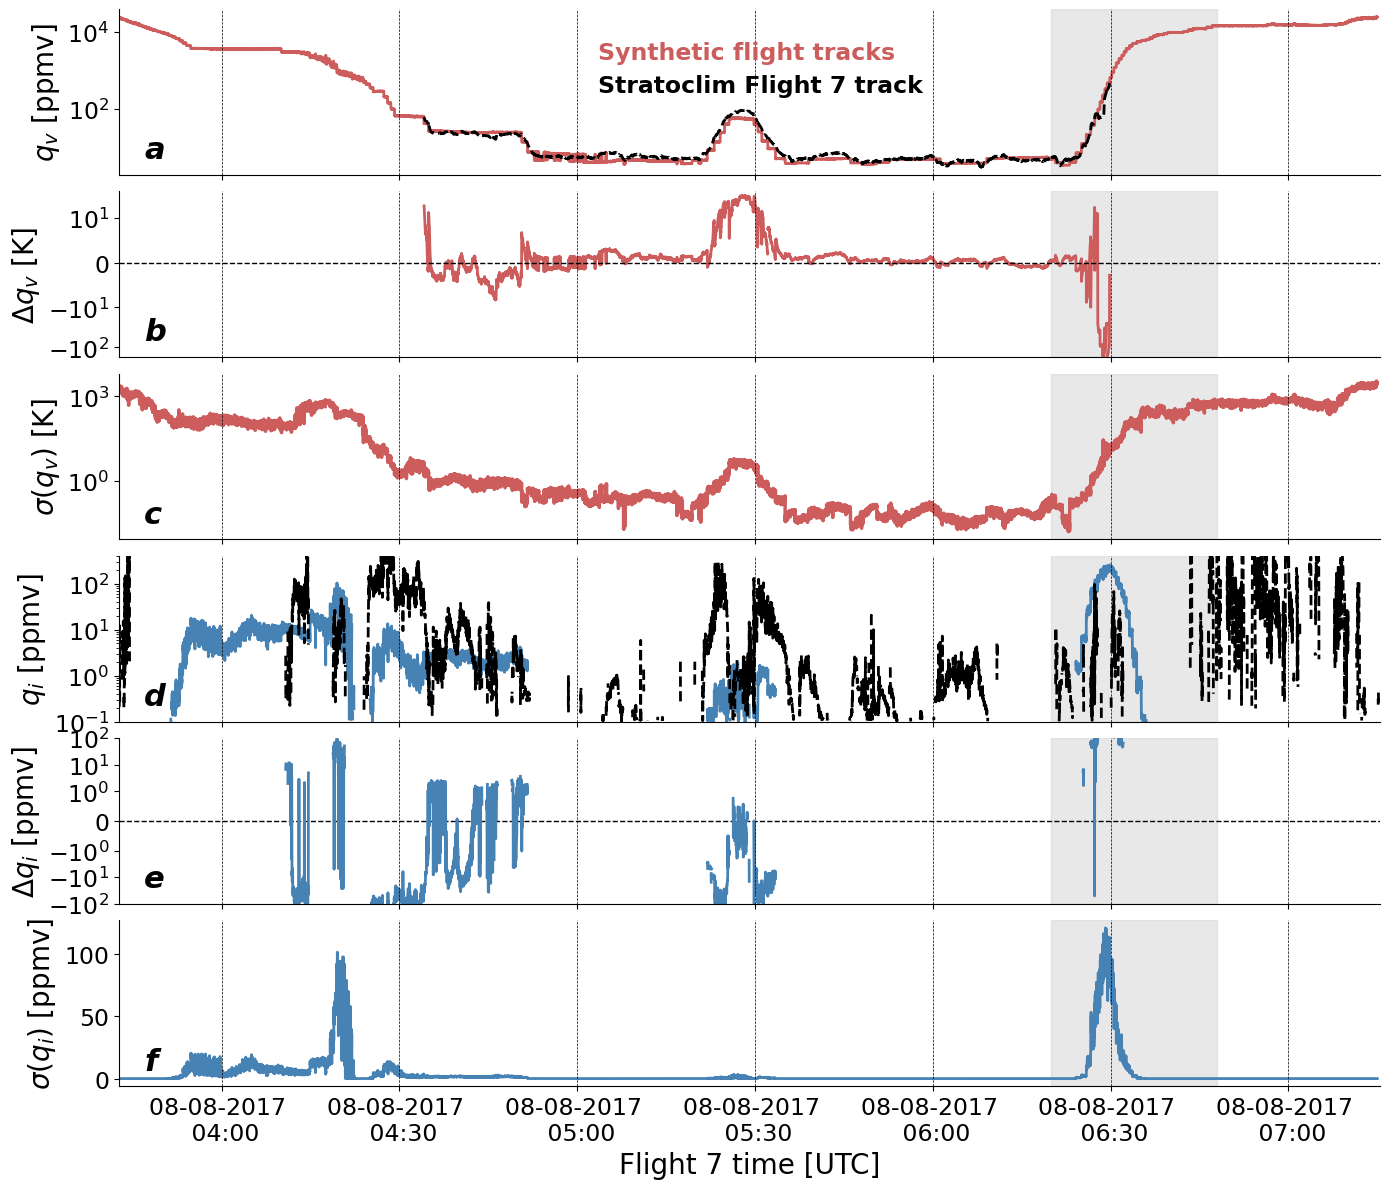

In [58]:
fs = 17
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(14,12))
let = ['a', 'b', 'c', 'd', 'e','f']
for a, l, i in zip(ax, let, np.arange(6)):
    a.set_xlim( [t.min(), t.max()] )
    a.axvspan( np.datetime64('2017-08-08T06:20'), np.datetime64('2017-08-08T06:48'), color='lightgray', alpha=0.5 )
    sexy_axes(a, fs=fs, r=False)
    a.text(0.02, 0.1, l, weight='bold', style='italic', fontsize=fs+5, transform=a.transAxes)
    if i < 5:
        a.set_xticklabels([])
        
qvm = np.nanmean( qv_sim, axis=1 )
qvstd = np.nanstd( qv_sim, axis=1 )
qim = np.nanmean( qi_sim, axis=1 )
qistd = np.nanstd( qi_sim, axis=1 )

ax[0].plot(t, qvm, color='indianred', lw=2)
ax[0].plot(t_Stratoclim, qv_Stratoclim2, color='k', lw=2, ls='--')
ax[0].set_yscale( 'log' )
ax[0].set_ylabel(r'$q_v$ [ppmv]', fontsize=fs+3)
ax[0].text(0.38, 0.5, 'Stratoclim Flight 7 track', weight='bold', fontsize=fs, transform=ax[0].transAxes)
ax[0].text(0.38, 0.7, 'Synthetic flight tracks',  weight='bold', fontsize=fs, color='indianred', transform=ax[0].transAxes)

ax[1].plot(t, qv_Stratoclim2 - qvm, color='indianred', linewidth=2)
ax[1].axhline( y=0, color='k', ls='--', lw=1 )
ax[1].set_ylabel(r'$\Delta q_v$ [K]', fontsize=fs+3)
ax[1].set_yscale( 'symlog', linthresh=1e1 )

ax[2].plot(t, qvstd, color='indianred', linewidth=2.5)
ax[2].set_ylabel(r'$\sigma(q_v)$ [K]', fontsize=fs+3)
ax[2].set_yscale( 'log' )

qi_nan = np.where( qim > 0.1, qim, np.nan )
qi_Stratoclim_nan = np.where( qi_Stratoclim > 0.1, qi_Stratoclim, np.nan )
ax[3].plot(t, qi_nan, color='steelblue', lw=2)
ax[3].plot(t, qi_Stratoclim_nan, color='k', ls='--', lw=2)
ax[3].set_ylabel( '$q_i$ [ppmv]', fontsize=fs+3 )
ax[3].set_yscale( 'log' )
ax[3].set_ylim( [0.1, 400] )

ax[4].axhline( y=0, color='k', ls='--', lw=1 )
ax[4].plot(t, qi_nan - qi_Stratoclim_nan, color='steelblue', lw=2)
ax[4].set_ylabel( '$\Delta q_i$ [ppmv]', fontsize=fs+3 )
ax[4].set_ylim( [-100, 100] )
ax[4].set_yscale( 'symlog', linthresh=1 )

ax[5].plot(t, qistd, color='steelblue', lw=2)
ax[5].set_ylabel( r'$\sigma (q_i)$ [ppmv]', fontsize=fs+3 )
ax[5].set_xticklabels(['08-08-2017 \n 04:00', '08-08-2017 \n 04:30','08-08-2017 \n 05:00','08-08-2017 \n 05:30',
    '08-08-2017 \n 06:00','08-08-2017 \n 06:30','08-08-2017 \n 07:00'])
ax[5].set_xlabel('Flight 7 time [UTC]', fontsize=fs+3)

for xtick in ax[5].get_xticks():
    for a in ax:
        a.axvline(x=xtick, color='k', ls='--', lw=0.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
fig.savefig('output/syn-flight-track-qi-qv-check.pdf',bbox_inches='tight')
plt.show()

# Figure 5: Temperature and specific humidity profile comparisons

In [4]:
# Which set of trajectory statistics do you want to open?

tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_P' # P = 'pinpoint', find the closest numerical value to the obs within the sim
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )

In [8]:
min_alt = 5000
max_alt = 22000
icon_sz = 50
    
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

In [9]:
# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Text(0.03, 0.93, 'd')

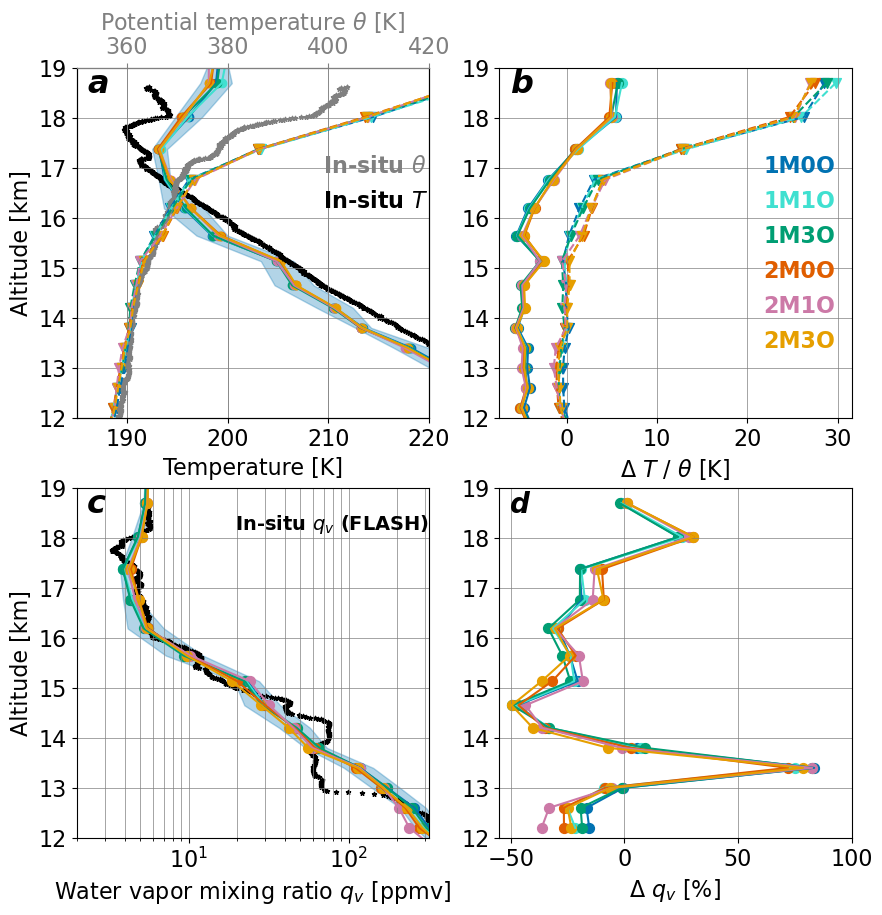

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0 = ax[0,0].twiny()
axs = list(ax.flatten())
axs.append( ax0 )

# Other plotting parameters
icon_lw = 1.5
icon_alfa = 1
fs = 16
yval = bins_sims/1000

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 0

# Axis limits specified
for a in axs:
    a.set_ylim([12, 19])
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    a.tick_params('both',labelsize=fs)
#ax[0,1].set_xlim([-5, 7])
ax[1,0].set_xlim([2, 10**2.5])
ax[1,1].set_xlim([-55,100])

# Align grid lines on PANEL A
ax[0,0].set_xlim([185, 220])
ax0.set_xlim([2*185 - 20, 2*220 - 20])
xticks_ax = [190, 200, 210, 220]
xticks_ax0 = [2*x - 20 for x in xticks_ax]
ax[0,0].set_xticks(xticks_ax)
ax0.set_xticks(xticks_ax0)

# Set matching ticks and gridlines
xticks_ax = [190, 200, 210, 220]
xticks_ax0 = [2*x - 20 for x in xticks_ax] 

# PANEL A: Mean (or median) temperature over all trajectories
tm = np.nanmean( stats[0]['temp_'+k], axis=1 )
tstd = np.nanmean( stats[0]['temp_std'], axis=1 )
# Shade the area for +/- a standard deviation for the first simulation
ax[0,0].fill_betweenx( y=yval, x1=tm-tstd, x2=tm+tstd, alpha=0.3, color=farbe['1M0O'] )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    ax[0,0].scatter( tm, yval, color=farbe[sl] )
    ax[0,0].plot( tm, yval, lw=icon_lw, color=farbe[sl] )
ax[0,0].scatter(temp, alt3/1000, color='k', s=10, marker='*')
ax[0,0].set_xlabel('Temperature [K]', fontsize=fs)
ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[0,0].text(0.03, 0.93, 'a', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,0].transAxes)

# PANEL A: Potential temperature 
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    thetastd = np.nanmean( stats[i]['theta_std'], axis=1 )
    ax0.scatter( thetam, yval, marker='v', s=icon_sz, color=farbe[sl] )
    ax0.plot( thetam, yval, lw=icon_lw, ls='--', color=farbe[sl] )
ax0.scatter(theta, alt3/1000, color='gray', s=10, marker='*')
ax0.set_xlabel(r'Potential temperature $\theta$ [K]', fontsize=fs, color='gray')
ax0.spines['top'].set_color('gray')
ax0.tick_params(axis='x',colors='gray')
ax0.text(0.7, 0.7, r'In-situ $\theta$', fontsize=fs, weight='bold', color='gray', transform=ax0.transAxes)
ax0.text(0.7, 0.6, r'In-situ $T$', fontsize=fs, weight='bold', color='black', transform=ax0.transAxes)

# PANEL B: Temperature and theta anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    ax[0,1].scatter( tm-temp_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( tm-temp_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
    ax[0,1].text(0.75, 0.7-i*0.1, sl, fontsize=fs, weight='bold', color=farbe[sl], transform=ax[0,1].transAxes)
    if i == 0: # switch reference to 3 if interested in 2M
        reference_bias = tm-temp_SC_stats[l]
    now_bias = tm-temp_SC_stats[l]
    #print( yval[:-24] ) # See only altitudes from 14 km upward
    #print( (now_bias[:-24] - reference_bias[:-24])/reference_bias[:-24]*100 )
    ax[0,1].scatter( thetam-theta_SC_stats[l], yval, s=icon_sz, marker='v', alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( thetam-theta_SC_stats[l], yval, lw=icon_lw, ls='--', color=farbe[sl] )
ax[0,1].set_xlabel(r'$\Delta$ $T$ / $\theta$ [K]', fontsize=fs)
ax[0,1].text(0.03, 0.93, 'b', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,1].transAxes)

# PANEL C: Mean (or median) specific humidity across all trajectories
qvm = np.nanmean( stats[0]['qv_'+k], axis=1 )
qvstd = np.nanmean( stats[0]['qv_std'], axis=1 )
ax[1,0].fill_betweenx( y=yval, x1=qvm-qvstd, x2=qvm+qvstd, alpha=0.3, color=farbe['1M0O'] )
ax[1,0].scatter( qv_flash, alt1/1000, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['qv_'+k], axis=1 )
    ax[1,0].scatter( qvm, yval, s=icon_sz, color=farbe[sl] )
    ax[1,0].plot( qvm, yval, lw=icon_lw, color=farbe[sl] )
ax[1,0].text(0.45, 0.88, 'In-situ $q_v$ (FLASH)', fontsize=fs-2, weight='bold', transform=ax[1,0].transAxes)
ax[1,0].set_xlabel('Water vapor mixing ratio $q_v$ [ppmv]',fontsize=fs)
ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[1,0].set_xscale('log')
ax[1,0].text(0.03, 0.93, 'c', weight='bold', style='italic', fontsize=fs+7, transform=ax[1,0].transAxes)

# PANEL D: Specific humidity anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['qv_'+k], axis=1 )
    ax[1,1].scatter( (qvm-qv_flash_SC_stats[l])/qv_flash_SC_stats[l]*100, yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[1,1].plot( (qvm-qv_flash_SC_stats[l])/qv_flash_SC_stats[l]*100, yval, lw=icon_lw, color=farbe[sl])
ax[1,1].set_xlabel(r'$\Delta$ $q_v$ [%]', fontsize=fs)
ax[1,1].text(0.03, 0.93, 'd', weight='bold', style='italic', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig( 'output/T-qv-profile-comparison' + tag + '.pdf', bbox_inches='tight' )

# Figure 6: Joint distribution of temperature and moisture biases

In [61]:
# Which set of synthetic trajectory files to read?
tag = '_E'  # E = 'extract', default 500 synthetic trajectories
#tag = '_2E' # Second (or third) set of 500 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_P' # P = 'pinpoint', find the closest numerical value to the obs within the sim
#tag = '_full' # Statistics over the full Flight 7 track

# Read in the synthetic trajectory files and save temperature and qv biases
bd = '/groups/sylvia/UTLS-profiles/output/'
bd2 = '/groups/sylvia/UTLS-profiles/obs/'
vals = np.zeros( (6, 2, 12770) )
#t_vals = np.zeros( (6, 2, 12770) )
#qv_vals = np.zeros( (6, 2, 12770) )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    ds2 = xr.open_dataset( bd2 + 'stratoclim2017.geophysika.0808_1.filtered_per_sec.nc' )
    alt_obs = ds2['BEST:ALT']
    t_obs = ds2['BEST:TEMP']
    qv_obs = ds2['BEST:H2O_gas']
    
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_' + sl + tag + '.nc' )
    t_sim = ds['temp'][:,0]
    qv_sim = ds['qv'][:,0] * conv * 10**6
    w_sim = ds['w'][:,0]
    
    # Filter only for UTLS values
    t_obs = xr.where( alt_obs > 14000, t_obs, np.nan )
    qv_obs = xr.where( alt_obs > 14000, qv_obs, np.nan )
    t_sim = xr.where( alt_obs > 14000, t_sim, np.nan )
    qv_sim = xr.where( alt_obs > 14000, qv_sim, np.nan )

    # Calculate biases in temperature and specific humidity
    vals[i,0] = t_sim - t_obs
    vals[i,1] = (qv_sim - qv_obs)/qv_obs*100
    
    #t_vals[i,0] = t_sim
    #t_vals[i,1] = t_obs
    #qv_vals[i,0] = qv_sim
    #qv_vals[i,1] = qv_obs 

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


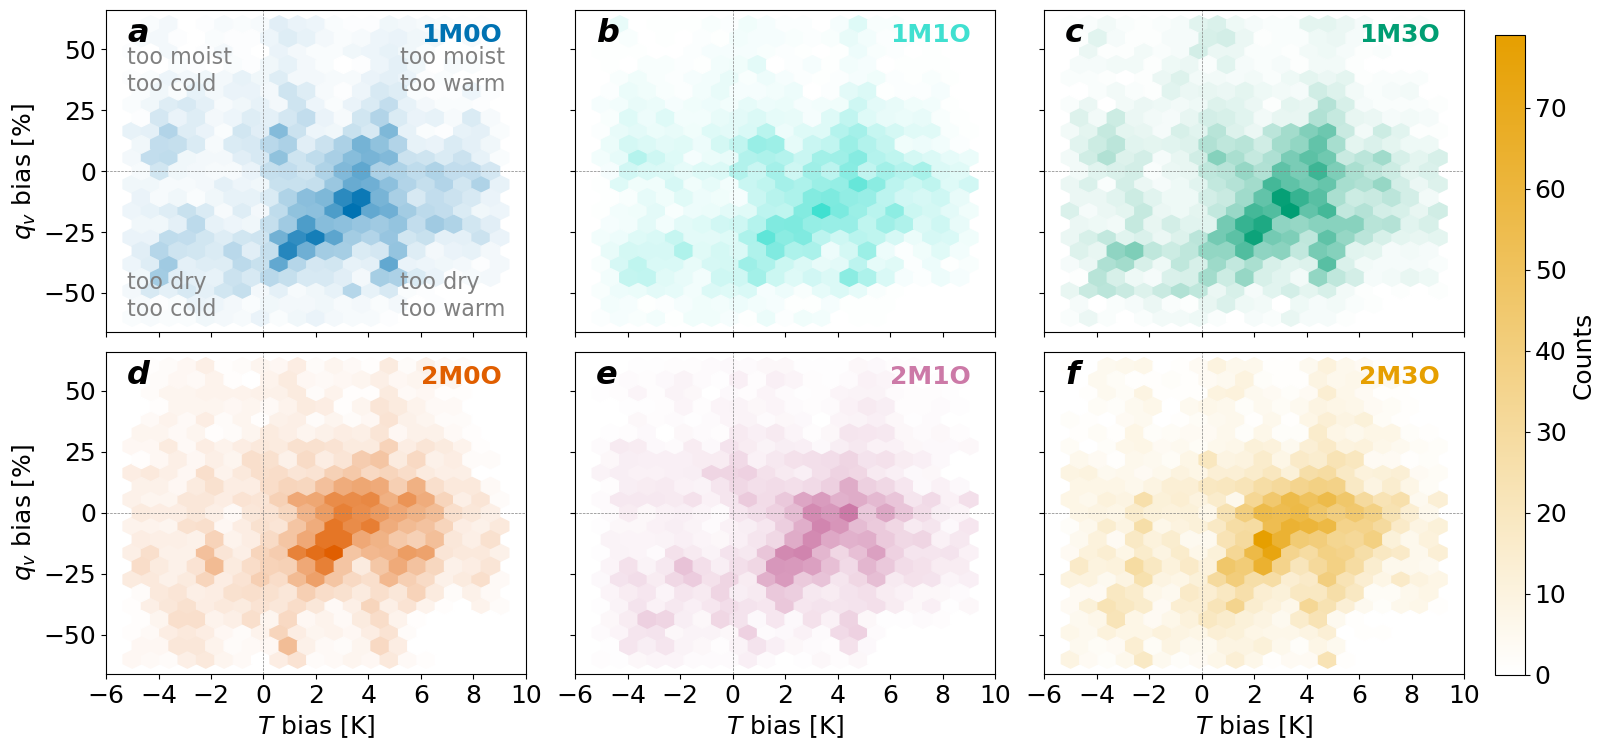

In [85]:
fs = 18
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
panel_labels = ['a','b','c','d','e','f']

for (idx, ax), sl in zip(enumerate(axs.flat), sim_list):
    # Create a contourf plot with the temperature and specific humidity biases
    cmap = LinearSegmentedColormap.from_list("custom_seq", ["white", farbe[sl]])
    hb = ax.hexbin( vals[idx,0], vals[idx,1], gridsize=20, extent=[-5, 9, -60, 60], cmap=cmap )
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.tick_params(labelsize=fs)
    if idx % 3 == 0:
        ax.set_ylabel(r"$q_v$ bias [%]", fontsize=fs)
    if idx // 3 == 1:
        ax.set_xlabel(r"$T$ bias [K]", fontsize=fs)
    ax.text(0.05, 0.9, panel_labels[idx], transform=ax.transAxes, fontstyle='italic', fontsize=fs+5, fontweight='bold')
    ax.text(0.75, 0.9, sl, transform=ax.transAxes, fontsize=fs, color=farbe[sl], fontweight='bold')

axs[0,0].text( 0.7, 0.75, 'too moist \ntoo warm', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )
axs[0,0].text( 0.7, 0.05, 'too dry \ntoo warm', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )
axs[0,0].text( 0.05, 0.75, 'too moist \ntoo cold', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )
axs[0,0].text( 0.05, 0.05, 'too dry \ntoo cold', color='gray', fontsize=fs-2, transform=axs[0,0].transAxes )

for ax in axs.flat:
    ax.set_xticks(np.arange(-6, 11, 2))

# Create a single vertical colorbar spanning both rows of subplots
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label('Counts', fontsize=fs)
cbar.ax.tick_params(labelsize=fs)
plt.tight_layout(rect=[0, 0, 1, 0.95])

#fig.savefig( 'output/T-qv-joint-distributions' + tag + '.pdf', bbox_inches='tight' )
plt.show()

-9.794082641601562 0.020180926917188396 10.018600463867188
-215.90776375085684 1.1798506778040212 206.44142760134582
-9.932373046875 -0.09891477076340215 8.774703979492188
-196.82153480830877 -0.41592939667370266 199.86381552452363
-9.941604614257812 0.11149420793610736 9.297821044921875
-192.73902454136854 1.1714674989792846 243.0665185892015
-9.113372802734375 0.11438729666268553 8.927017211914062
-204.69543085654809 2.478959179130971 257.83572607484473
-10.021377563476562 0.1693678888309708 9.39556884765625
-218.42646279483384 0.3940516700316267 177.54698860567453


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


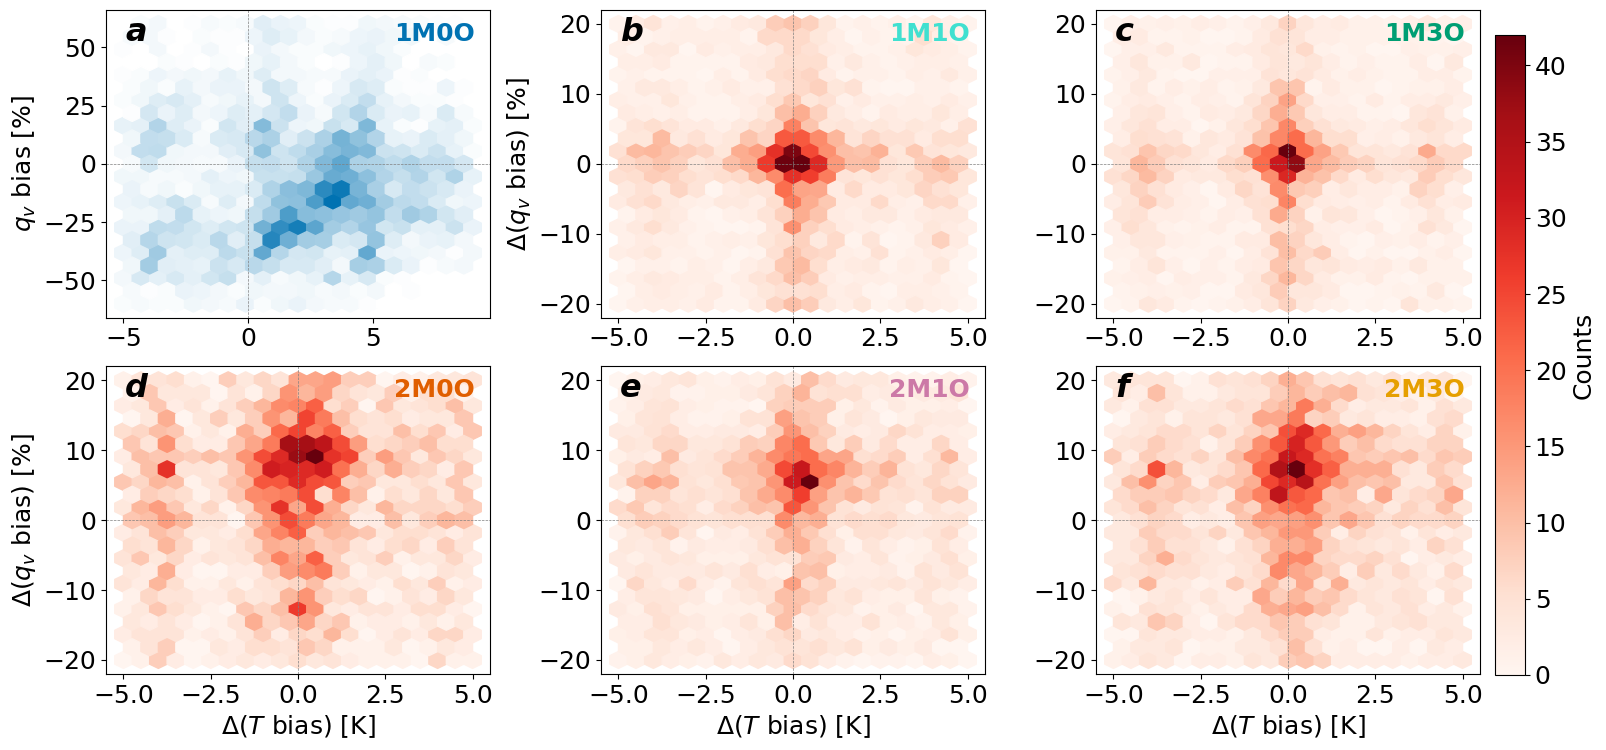

In [89]:
fs = 18
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
panel_labels = ['a','b','c','d','e','f']

for (idx, ax), sl in zip(enumerate(axs.flat), sim_list):
    # Create a contourf plot with the temperature and specific humidity biases
    if idx == 0:
        cmap = LinearSegmentedColormap.from_list("custom_seq", ["white", farbe[sl]])
        ax.hexbin( vals[idx,0], vals[idx,1], gridsize=20, extent=[-5, 9, -60, 60], cmap=cmap )
    else:
        print( np.nanmin(vals[idx,0]-vals[0,0]), np.nanmean(vals[idx,0]-vals[0,0]), np.nanmax(vals[idx,0]-vals[0,0]) )
        print( np.nanmin(vals[idx,1]-vals[0,1]), np.nanmean(vals[idx,1]-vals[0,1]), np.nanmax(vals[idx,1]-vals[0,1]) )
        hb = ax.hexbin( vals[idx,0]-vals[0,0], vals[idx,1]-vals[0,1], gridsize=20, extent=[-5, 5, -20, 20], cmap='Reds' )
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.tick_params(labelsize=fs)
    if idx == 0:
        ax.set_ylabel(r"$q_v$ bias [%]", fontsize=fs)
    if idx == 1 or idx == 3:
        ax.set_ylabel(r"$\Delta (q_v$ bias) [%]", fontsize=fs)
    if idx // 3 == 1:
        ax.set_xlabel(r"$\Delta (T$ bias) [K]", fontsize=fs)
    ax.text(0.05, 0.9, panel_labels[idx], transform=ax.transAxes, fontstyle='italic', fontsize=fs+5, fontweight='bold')
    ax.text(0.75, 0.9, sl, transform=ax.transAxes, fontsize=fs, color=farbe[sl], fontweight='bold')

# Create a single vertical colorbar spanning both rows of subplots
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label('Counts', fontsize=fs)
cbar.ax.tick_params(labelsize=fs)
plt.tight_layout(rect=[0, 0, 1, 0.95])

fig.savefig( 'output/T-qv-joint-distributions-differences' + tag + '.pdf', bbox_inches='tight' )
plt.show()

# Figure 7: Temperature and specific humidity comparison with other data sources

In [18]:
# Reanalysis data
bd = '/groups/sylvia/UTLS-profiles/obs/'
era5_data = xr.open_dataset( bd + '2017-08-08-ERA5-vertical-profiles.nc' )

# Extract temperature and average it over the whole box
era5_temperature = era5_data.t.mean( dim=['latitude', 'longitude', 'valid_time'] )

# Extract specific humidity, convert it to ppmv, and average it over the whole box
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
era5_qv = era5_data.q.mean( dim=['latitude', 'longitude', 'valid_time'] ) * conv * 10**6

In [19]:
# MLS data
filename = 'MLS-Aura_L2GP-Temperature_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_temperature = f['HDFEOS/SWATHS/Temperature/Data Fields/Temperature'][:]  # (3495, 55)
    lat = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Latitude'][:] # (3495, )
    lon = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure1 = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (lon >= 80) & (lon <= 90) & (lat >= 19) & (lat <=30) )
mls_temperature_filtered = mls_temperature[mask, :]

filename = 'MLS-Aura_L2GP-H2O_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_h2o = f['HDFEOS/SWATHS/H2O/Data Fields/H2O'][:]  # (3495, 55)
    #print( f['HDFEOS/SWATHS/H2O/Data Fields/H2O'].attrs['Units'] ) # Return units of H2O
    lat = f['HDFEOS/SWATHS/H2O/Geolocation Fields/Latitude'][:] # (3495, )
    lon = f['HDFEOS/SWATHS/H2O/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure2 = f['HDFEOS/SWATHS/H2O/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (lon >= 80) & (lon <= 90) & (lat >= 19) & (lat <=30) )
mls_h2o_filtered = mls_h2o[mask, :] * 10**6  # convert from a unitless volumetric mixing ratio to ppmv

In [20]:
# Sonde data
sonde_id = [ '42182', '42867', '42089' ]
sonde_list_temperature = []
sonde_list_pressure = []
sonde_list_qv = []
for i in sonde_id:
    fi = bd + 'Sonde-' + i + '-20170808T00.txt'
    df_raw = pd.read_csv( fi, sep='\s+', header=None, engine='python' )
    
    # Use the first row of text as column headers
    new_columns = [f"{var} [{unit}]" for var, unit in zip(df_raw.iloc[0], df_raw.iloc[1])]
    df_raw.columns = new_columns
    df_clean = df_raw.drop(index=[0, 1]).reset_index(drop=True).astype(float)

    # Append the temperature, qv, and pressure to sonde_list_temperature
    sonde_list_temperature.append( df_clean['TEMP [C]'].values + 273 )
    p = df_clean['PRES [hPa]'].values
    sonde_list_pressure.append( p )
    qv_clean = df_clean['MIXR [g/kg]'].values * conv * 10**3
    sonde_list_qv.append( np.where( p > 120, qv_clean, np.nan) ) # not sure of rationale for the 120 threshold here

In [24]:
# Create mean sonde data also by interpolating to a set of reference pressures across all sites
interpolated_temperatures = []
interpolated_qv = []
ref_pressure = sonde_list_pressure[0]
for p, t, q in zip(sonde_list_pressure, sonde_list_temperature, sonde_list_qv):
    sort_idx = np.argsort(p)[::-1]
    p_sorted = p[sort_idx]
    t_sorted = t[sort_idx]
    q_sorted = q[sort_idx]

    f_interp = interp1d( p_sorted, t_sorted, kind='linear', bounds_error=False, fill_value=np.nan )
    interp_t = f_interp( ref_pressure )
    f_interp = interp1d( p_sorted, q_sorted, kind='linear', bounds_error=False, fill_value=np.nan )
    interp_q = f_interp( ref_pressure )
    
    interpolated_temperatures.append( interp_t )
    interpolated_qv.append( interp_q )

In [49]:
# Simulation data averaged over the whole domain, not just the flight track
sim_ds = xr.open_dataset( '/groups/sylvia/UTLS-profiles/output/mean-T-qv-profiles.nc' )
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


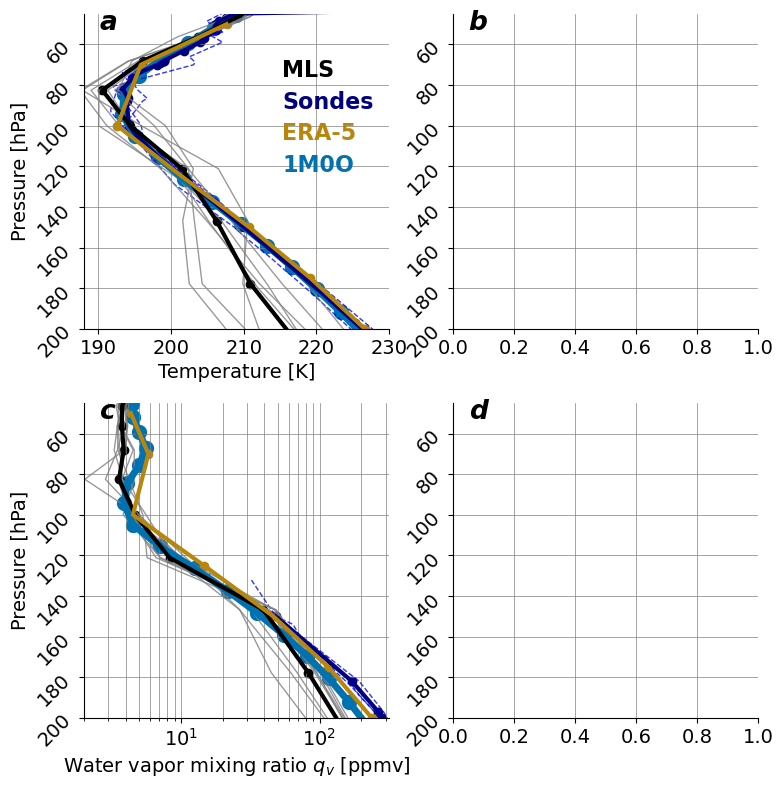

In [61]:
lw = 3
fs = 14
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
let = ['a','b','c','d']
ax[0,0].text( 0.65, 0.8, 'MLS', color=farbe['MLS'], weight='bold', fontsize=fs+2, transform=ax[0,0].transAxes )
ax[0,0].text( 0.65, 0.7, 'Sondes', color=farbe['Sonde'], weight='bold', fontsize=fs+2, transform=ax[0,0].transAxes )
ax[0,0].text( 0.65, 0.6, 'ERA-5', color=farbe['ERA'], weight='bold', fontsize=fs+2, transform=ax[0,0].transAxes )
ax[0,0].text( 0.65, 0.5, '1M0O', color=farbe['1M0O'], weight='bold', fontsize=fs+2, transform=ax[0,0].transAxes )

for i, a in enumerate(ax.flatten()):
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    a.invert_yaxis()
    a.set_ylim( [200, 45] )
    a.tick_params( labelsize=fs )
    a.tick_params( axis='y', labelrotation=45 )
    a.text( 0.05, 0.95, let[i], fontsize=fs+5, style='italic', weight='bold', transform=a.transAxes )
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    if i %2 == 0:
        a.set_ylabel( 'Pressure [hPa]', fontsize=fs )

for j in range(len(sonde_id)):
    ax[0,0].plot( sonde_list_temperature[j], sonde_list_pressure[j], lw=1, alpha=0.8, color='blue', ls='--' )
    ax[1,0].plot( sonde_list_qv[j], sonde_list_pressure[j], lw=1, alpha=0.8, color='blue', ls='--' )
    
for i in range(8):
    ax[0,0].plot( mls_temperature_filtered[i], mls_pressure1, lw=1, alpha=0.8, color='gray' )
    ax[1,0].plot( mls_h2o_filtered[i], mls_pressure2, lw=1, alpha=0.8, color='gray' )

# PANEL A: Temperature profiles
mean_sonde_temperature = np.nanmean( interpolated_temperatures, axis=0 )
mean_sonde_pressure = ref_pressure
sim_temperature = sim_ds.sel(simulation='1M0O')['mean_T']
ax[0,0].scatter( sim_temperature, sim_ds.pressure/100, lw=lw+2, color=farbe['1M0O'] )
ax[0,0].plot( sim_temperature, sim_ds.pressure/100, lw=lw+2, color=farbe['1M0O'] )
ax[0,0].scatter( mean_sonde_temperature, mean_sonde_pressure, color=farbe['Sonde'] )
ax[0,0].plot( mean_sonde_temperature, mean_sonde_pressure, lw=lw, color=farbe['Sonde'] )
ax[0,0].scatter( np.nanmean( mls_temperature_filtered, axis=0 ), mls_pressure1, color=farbe['MLS'] )
ax[0,0].plot( np.nanmean( mls_temperature_filtered, axis=0 ), mls_pressure1, lw=lw, color=farbe['MLS'] )
ax[0,0].scatter( era5_temperature, era5_data.pressure_level, color=farbe['ERA'] )
ax[0,0].plot( era5_temperature, era5_data.pressure_level, lw=lw, color=farbe['ERA'] )
ax[0,0].set_xlim( [188, 230] )
ax[0,0].set_xlabel( 'Temperature [K]', fontsize=fs )

# PANEL B: Temperature differences
#ax[0,0].scatter( mean_sonde_temperature - sim_temperature )

# PANEL C: Humidity profiles
mean_sonde_qv = np.nanmean( interpolated_qv, axis=0 )
sim_qv = sim_ds.sel(simulation='1M0O')['mean_qv'] * conv * 10**6
ax[1,0].scatter( sim_qv, sim_ds.pressure/100, lw=lw+2, color=farbe['1M0O'] )
ax[1,0].plot( sim_qv, sim_ds.pressure/100, lw=lw+2, color=farbe['1M0O'] )
ax[1,0].scatter( mean_sonde_qv, mean_sonde_pressure, color=farbe['Sonde'] )
ax[1,0].plot( mean_sonde_qv, mean_sonde_pressure, lw=lw, color=farbe['Sonde'] )
ax[1,0].scatter( np.nanmean( mls_h2o_filtered, axis=0 ), mls_pressure2, color=farbe['MLS'] )
ax[1,0].plot( np.nanmean( mls_h2o_filtered, axis=0 ), mls_pressure2, lw=lw, color=farbe['MLS'] )
ax[1,0].scatter( era5_qv, era5_data.pressure_level, color=farbe['ERA']  )
ax[1,0].plot( era5_qv, era5_data.pressure_level, lw=lw, color=farbe['ERA'] )
ax[1,0].set_xscale( 'log' )
ax[1,0].set_xlim( [2, 10**2.5] )
ax[1,0].set_xlabel( r'Water vapor mixing ratio $q_v$ [ppmv]', fontsize=fs )

plt.tight_layout()

# Figure 8: Relative humidity and ice mass mixing ratio profile comparisons

In [31]:
# Which set of trajectory statistics do you want to open?

tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_P' # P = 'pinpoint', find the closest numerical value to the obs within the sim
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )

In [32]:
min_alt = 5000
max_alt = 22000
icon_sz = 50
    
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

In [33]:
# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


Text(0.03, 0.93, 'c')

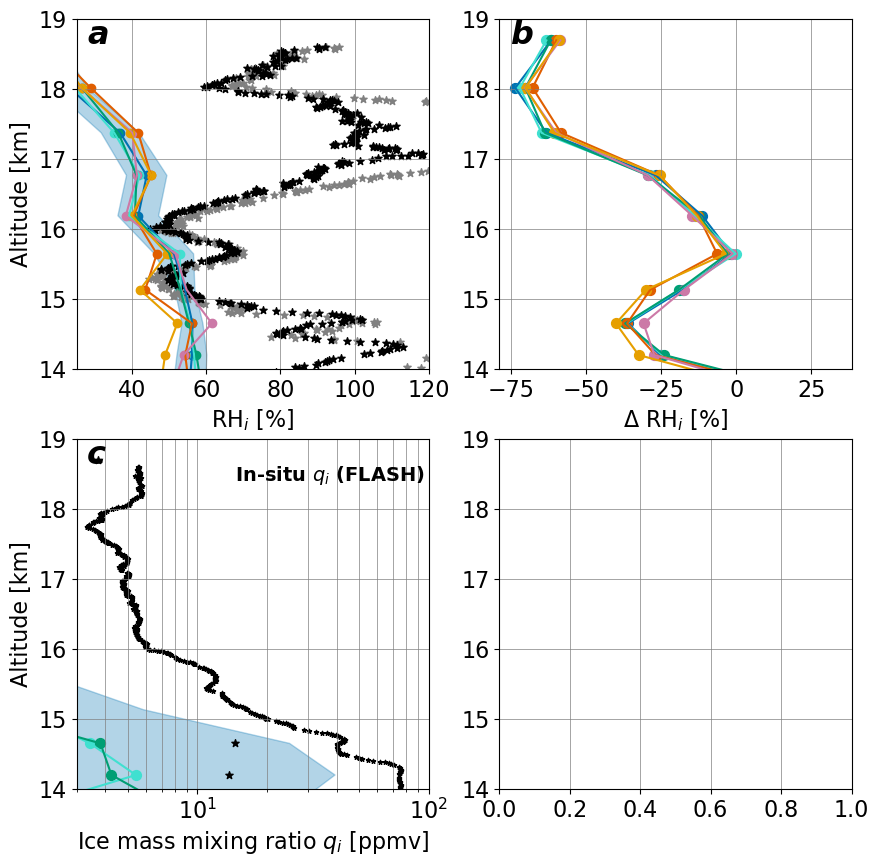

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs = list(ax.flatten())

# Other plotting parameters
icon_lw = 1.5
icon_alfa = 1
fs = 16
yval = bins_sims/1000

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'median'; l = 1

# Axis limits specified
for a in axs:
    a.set_ylim([14, 19])
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    a.tick_params('both',labelsize=fs)
ax[0,0].set_xlim([25, 120])
ax[1,0].set_xlim([3*10**0, 10**2])
#ax[1,1].set_xlim([-30, 5])

# PANEL A: Mean (or median) RHice over all trajectories
rhim = np.nanmedian( stats[0]['rh_'+k], axis=1 )
rhistd = np.nanmean( stats[0]['rh_std'], axis=1 )
# Shade the area for +/- a standard deviation for the first simulation
ax[0,0].fill_betweenx( y=yval, x1=rhim-rhistd, x2=rhim+rhistd, alpha=0.3, color=farbe['1M0O'] )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    rhim = np.nanmedian( stats[i]['rh_'+k], axis=1 )
    ax[0,0].scatter( rhim, yval, color=farbe[sl] )
    ax[0,0].plot( rhim, yval, lw=icon_lw, color=farbe[sl] )
ax[0,0].scatter(rhice_fish, alt4/1000, color='gray', s=30, marker='*')
ax[0,0].scatter(rhice_flash, alt4/1000, color='k', s=30, marker='*')
ax[0,0].set_xlabel(r'RH$_i$ [%]', fontsize=fs)
ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[0,0].text(0.03, 0.93, 'a', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,0].transAxes)

# PANEL B: RHi anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    rhim = np.nanmean( stats[i]['rh_'+k], axis=1 )
    ax[0,1].scatter( rhim-RHi_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( rhim-RHi_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
ax[0,1].set_xlabel(r'$\Delta$ RH$_i$ [%]', fontsize=fs)
ax[0,1].text(0.03, 0.93, 'b', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,1].transAxes)

# PANEL C: Mean (or median) qi over all trajectories
qim = np.nanmedian( stats[0]['qi_'+k], axis=1 )
qistd = np.nanmean( stats[0]['qi_std'], axis=1 )
ax[1,0].fill_betweenx( y=yval, x1=qim-qistd, x2=qim+qistd, alpha=0.3, color=farbe['1M0O'] )
ax[1,0].scatter( qv_flash, alt1/1000, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qim = np.nanmedian( stats[i]['qi_'+k], axis=1 )
    ax[1,0].scatter( qim, yval, s=icon_sz, color=farbe[sl] )
    ax[1,0].plot( qim, yval, lw=icon_lw, color=farbe[sl] )
ax[1,0].scatter(qi_SC_stats[0], bins_sims/1000, color='k', s=30, marker='*')
ax[1,0].text(0.45, 0.88, 'In-situ $q_i$ (FLASH)', fontsize=fs-2, weight='bold', transform=ax[1,0].transAxes)
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[1,0].set_xscale('log')
ax[1,0].text(0.03, 0.93, 'c', weight='bold', style='italic', fontsize=fs+7, transform=ax[1,0].transAxes)


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN

Text(0.03, 0.93, '(d)')

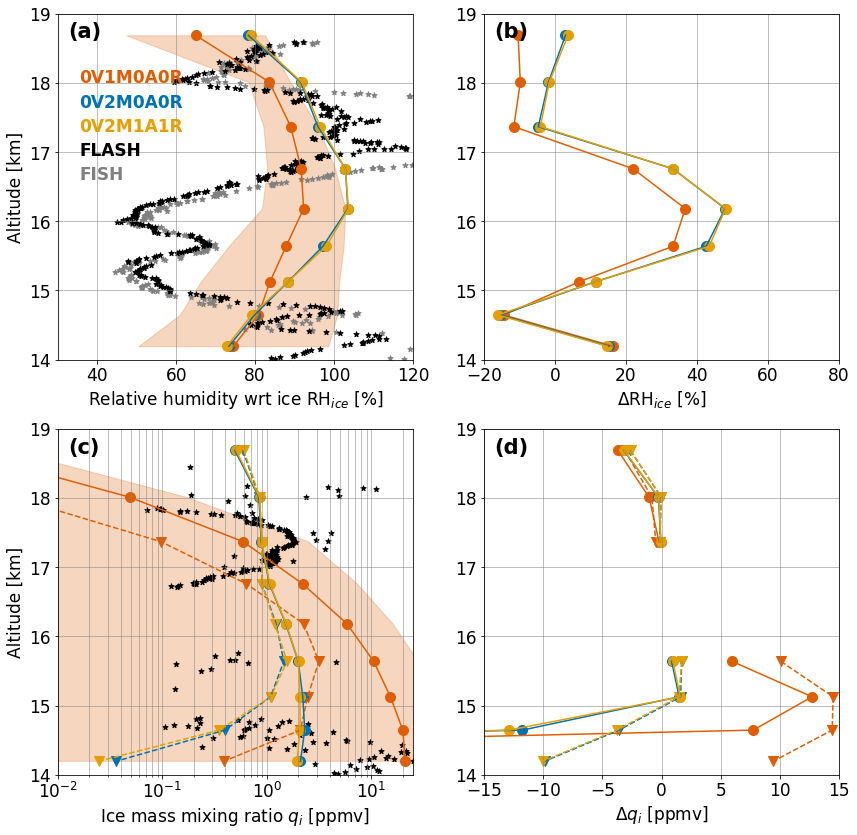

In [7]:
if tag == '_pinpoint':
    y1 = 14
    ax[0,1].set_xlim([-20, 20])
    ax[1,1].set_xlim([-5, 5])
    ax[0,0].set_xlim([30, 120])
    ax[1,0].set_xlim([0.01, 25])
elif tag != '_full':
    y1 = 14
    ax[0,1].set_xlim([-20, 80])
    ax[1,1].set_xlim([-15, 15])
    ax[0,0].set_xlim([30, 120])
    ax[1,0].set_xlim([0.01, 25])
else:
    ax[0,0].set_xlim([25, 120])
    ax[1,1].set_xlim([-100, 10])
    ax[1,0].set_xlim([10**(-6), 10**3])




# We don't use k below because we are showing both the mean and median always.
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,0].scatter(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xscale('log')
#ax[1,0].set_xlim([10**(-3),10**2])
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)
ax[1,0].set_ylabel('Altitude [km]', fontsize=fs)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,1].scatter(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,1].set_ylim([y1, y2])
#ax[1,1].set_xscale('log')
ax[1,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[1,1].tick_params('both',labelsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/RHi-qi-comp' + tag + '.pdf')

# Figure 9: Updraft velocity PDF + gravity wave spectrum

In [58]:
# Load the observational w values and evaluate their histogram.
basedir = '/xdisk/sylvia/tropic_vis/obs/POSIDON/'
posidon_winds = pd.read_csv(basedir + 'posidon_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
posidon_winds = posidon_winds[(posidon_winds['z'] >= 15)]
w_obs = posidon_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_POSIDON, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('POSIDON campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

basedir = '/xdisk/sylvia/tropic_vis/obs/ATTREX/'
attrex_winds = pd.read_csv(basedir + 'attrex3_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
attrex_winds = attrex_winds[(attrex_winds['z'] >= 15)]
w_obs = attrex_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_ATTREX, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('ATTREX campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

POSIDON campaign (mean, std) w: 0.08748738843285492 0.5858340614769502
ATTREX campaign (mean, std) w: -0.06651030636098923 0.23498594232830203


In [59]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Calculate the power spectral density of observational temperature and updraft signals.
basedir = '/xdisk/sylvia/tropic_vis/obs/BALLOON/Strateole-2/'
fi = [ 'ST2_C0_01_STR1_tsen.nc', 'ST2_C0_02_STR2_tsen.nc', 'ST2_C0_03_TTL3_tsen.nc', 'ST2_C0_04_TTL1_tsen.nc',
       'ST2_C0_05_TTL2_tsen.nc', 'ST2_C0_06_STR1_tsen.nc', 'ST2_C0_07_STR2_tsen.nc', 'ST2_C0_08_STR2_tsen.nc' ]
l = 0
for f in fi:
    l = l + xr.open_dataset( basedir + f )['time'].shape[0]

g = 9.8 # gravitational acceleration [m s-2]
cp = 1000 # specific heat capacity of air [J kg-1 K-1] at -70 C and 1 bar
Tprime = np.zeros((l,))
wprime = np.zeros((l,))
l = 0
for f in fi:
    alt = xr.open_dataset( basedir + f )['alt']
    zfluc = alt - np.nanmean(alt)
    tfluc = -zfluc * g / cp
    
    # Calculate the vertical velocity as the finite difference in altitude
    # divided by the 30 second temporal resolution
    w = np.diff(alt) / 30.
    wfluc = w - np.nanmean(w)
    
    wprime[l:l+len(wfluc)] = wfluc
    Tprime[l:l+len(tfluc)] = tfluc
    l = l + len(tfluc)
    
# Remove any nans from Tprime + wprime
Tprime = Tprime[~np.isnan(Tprime)]
wprime = wprime[~np.isnan(wprime)]

In [60]:
# Generate an instance of Class traj_psd with temp = input T time series
traj_obj = traj_psd( Tprime )
traj_obj2 = traj_psd( wprime )

# Calculate the power spectral density
ff, Pxx, _ = traj_obj.calc_psd()
ff2, Pxx2, _ = traj_obj2.calc_psd()
    
 # Interpolate the PSD to a fixed set of frequencies
f = interpolate.interp1d(ff, Pxx, kind='cubic')
T_PSD_Strateole = f(freq)
f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
w_PSD_Strateole = f2(freq)

In [62]:
# Load the trajectory frequencies and power spectral densities
bd = '/xdisk/sylvia/tropic_vis/'
T_ff_0V2M0A0R = np.load( bd + 'output/T_PSD_ff_0V2M0A0R_traj_ICON.npy' )
T_Pxx_0V2M0A0R = np.load( bd + 'output/T_PSD_Pxx_0V2M0A0R_traj_ICON.npy' )

T_ff_0V2M0A0R_Tf = np.load( bd + 'output/T_PSD_ff_0V2M0A0R_traj_Tf2.npy' )
T_Pxx_0V2M0A0R_Tf = np.load( bd + 'output/T_PSD_Pxx_0V2M0A0R_traj_Tf2.npy' )

w_ff_0V2M0A0R = np.load( bd + 'output/w_PSD_ff_0V2M0A0R_traj_ICON.npy' )
w_Pxx_0V2M0A0R = np.load( bd + 'output/w_PSD_Pxx_0V2M0A0R_traj_ICON.npy' )

# Load the updraft histograms from the ICON high-resolution simulations
h_0V2M0A0R = np.load( bd +  'output/traj_w_histogram_ICON_0V2M0A0R.npy' )
h_0V2M0A0R_1015km = np.load( bd + 'output/traj_w_histogram_ICON_0V2M0A0R_10-15km.npy' )

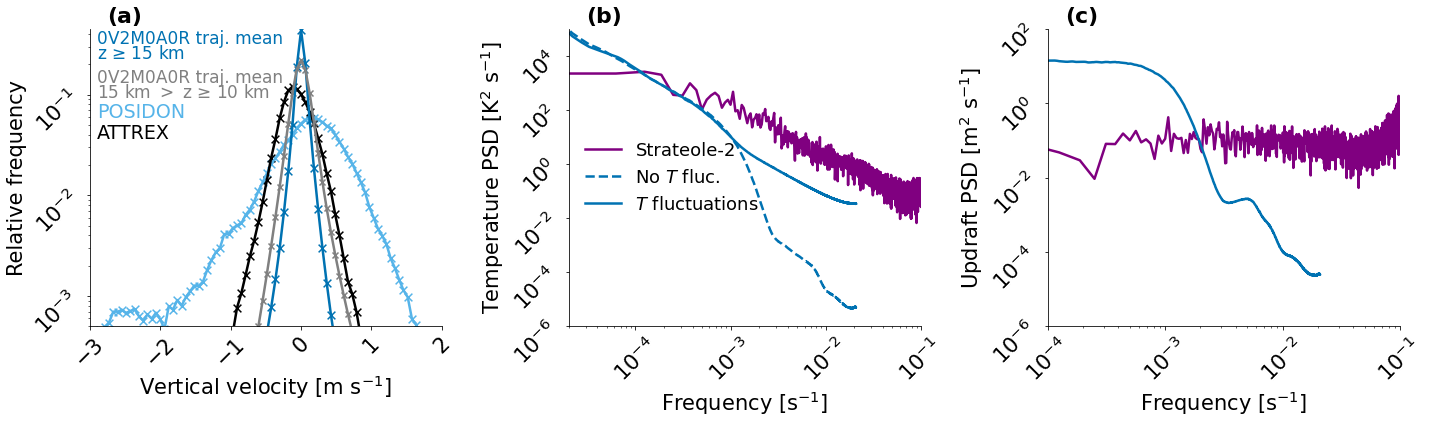

In [66]:
fs = 21
lw = 2.5
ms = 60

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_POSIDON, color=farbe['POSIDON'], lw=lw) # label='POSIDON'
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_ATTREX, color=farbe['ATTREX'], lw=lw) # label='ATTREX'
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_POSIDON, s=ms, marker='x', color=farbe['POSIDON'])
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_ATTREX, s=ms, marker='x', color=farbe['ATTREX'])

ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R,axis=0), lw=lw, color=farbe['0V2M0A0R']) # label='Traj. mean'
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R_1015km,axis=0), lw=lw, color='grey')
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R,axis=0), s=ms, marker='x', color=farbe['0V2M0A0R'])
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R_1015km,axis=0), marker='x', color='grey')

ax[0].text(0.05,1.02,'(a)', weight='bold', fontsize=fs+1, color='k', transform=ax[0].transAxes)
ax[0].text(0.02,0.95, '0V2M0A0R traj. mean', fontsize=fs-4, color=farbe['0V2M0A0R'], transform=ax[0].transAxes)
ax[0].text(0.02,0.90, 'z $≥$ 15 km', fontsize=fs-4, color=farbe['0V2M0A0R'], transform=ax[0].transAxes)
ax[0].text(0.02,0.82, r'0V2M0A0R traj. mean', fontsize=fs-4, color='grey', transform=ax[0].transAxes)
ax[0].text(0.02,0.77, '15 km $>$ z $≥$ 10 km', fontsize=fs-4, color='grey', transform=ax[0].transAxes)
ax[0].text(0.02,0.7, 'POSIDON', fontsize=fs-2, color=farbe['POSIDON'], transform=ax[0].transAxes)
ax[0].text(0.02,0.63, 'ATTREX', fontsize=fs-2, color=farbe['ATTREX'], transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].spines['right'].set_color('none')
ax[0].set_ylim([0.0005, 0.45])
ax[0].set_xlim([-3, 2])
ax[0].set_xlabel(r'Vertical velocity [m s$^{-1}$]',fontsize=fs)
ax[0].set_ylabel('Relative frequency',fontsize=fs)
sexy_axes(ax[0], fs)

ax[1].plot(freq, T_PSD_Strateole, color='purple', lw=lw, label='Strateole-2')
ax[2].plot(freq, w_PSD_Strateole, color='purple', lw=lw, label='Strateole-2')
ax[1].text(0.05,1.02,'(b)',weight='bold',fontsize=fs+1,color='k',transform=ax[1].transAxes)
ax[2].text(0.05,1.02,'(c)',weight='bold',fontsize=fs+1,color='k',transform=ax[2].transAxes)

ax[1].plot(np.nanmean(T_ff_0V2M0A0R,axis=0), np.nanmean(T_Pxx_0V2M0A0R,axis=0), ls='--', label=r'No $T$ fluc.', lw=lw, color=farbe['0V2M0A0R'])
ax[1].plot(np.nanmean(T_ff_0V2M0A0R_Tf,axis=0), np.nanmean(T_Pxx_0V2M0A0R_Tf,axis=0), label=r'$T$ fluctuations', lw=lw, color=farbe['0V2M0A0R'])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([2*10**-5, 0.1])
ax[1].set_ylim([10**-6, 10**5])
ax[1].legend(loc='center left', frameon=False, fontsize=fs-3)
ax[1].set_ylabel(r'Temperature PSD [K$^2$ s$^{-1}$]',fontsize=fs)
ax[1].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[1], fs)

#for j in np.arange(30):
#    ax[2].plot(w_ff_0V2M0A0R[j], w_Pxx_0V2M0A0R[j], color=colors[j], alpha=0.35)
ax[2].plot(np.nanmean(w_ff_0V2M0A0R,axis=0), np.nanmean(w_Pxx_0V2M0A0R,axis=0), linewidth=lw, color=farbe['0V2M0A0R'])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlim([10**-4, 0.1])
ax[2].set_ylim([10**(-6), 10**2])
ax[2].set_ylabel(r'Updraft PSD [m$^2$ s$^{-1}$]',fontsize=fs)
ax[2].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[2], fs)

plt.tight_layout()
#fig.savefig( bd + 'output/traj_dynamics.pdf',bbox_inches='tight' )
plt.show()

# Scraps - Calculating PSDs from flight track data (not to be compared to Lagrangian trajectories)

In [ ]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Number of POSIDON flights (9)
posidon_dates = posidon_winds['date'].unique()

# Calculate the power spectral density of observational temperature and updraft signals.
T_PSD_POSIDON = np.zeros((len(posidon_dates), n))
w_PSD_POSIDON = np.zeros((len(posidon_dates), n))

for j, date in enumerate(posidon_dates):
    subset = posidon_winds[(posidon_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 11176, 10480, 11190, 16964, 16208, 15551, 9612, 15899, 10114
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()
    
    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_POSIDON[j] = f(freq)
    w_PSD_POSIDON[j] = f2(freq)

In [ ]:
# Number of ATTREX flights (6)
attrex_dates = attrex_winds['date'].unique()

# Calculate the power spectral density of observational temperature signals.
T_PSD_ATTREX = np.zeros((len(attrex_dates), n))
w_PSD_ATTREX = np.zeros((len(attrex_dates), n))

for j, date in enumerate(attrex_dates):
    subset = attrex_winds[(attrex_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 39731, 37179, 32700, 46743, 50830, 36647
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()

    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_ATTREX[j] = f(freq)
    w_PSD_ATTREX[j] = f2(freq)